In [0]:
from pyspark.sql.functions import col, when,count, isnan, lit, skewness, regexp_extract, regexp_replace, length, trim, lower, concat_ws, udf, mean, stddev, min, max, kurtosis
from functools import reduce
from pyspark.sql.types import FloatType, IntegerType, LongType, ArrayType, StringType, StructType, StructField
from pyspark.sql import functions as F,  DataFrame
import joblib
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
import spacy

%pip install -U spacy
!python -m spacy download en_core_web_sm

# Create directory in DBFS
dbutils.fs.mkdirs("dbfs:/saved_columns")
# Load the uploaded CSV into a Spark DataFrame
df = spark.read.option("header", True).csv("/FileStore/tables/Sentiment_Reviews.csv")

# Show the first few rows
df.show(5)

# Optional: Check schema
df.printSchema()

2025-06-12 01:09:21.283364: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 01:09:21.465614: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 01:09:21.668010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749690561.817657    1321 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749690561.863891    1321 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 01:09:22.250169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/62.1 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/33.9 MB ? eta -:--:--
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/33.9 MB 131.3 MB/s eta 0:00:01
   ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/33.9 MB 89.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/33.9 MB 105.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 15.5/33.9 MB 115.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━ 19.6/33.9 MB 122.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 24.8/33.9 MB 132.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━ 28.5/33.9 MB 118.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 33.1/33.9 MB 122.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 33.9/33.9 MB 118.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 33.9/33.9 MB 118.

In [0]:
# Manually cast columns to appropriate data types
df = df.withColumn("Id", col("Id").cast(IntegerType())) \
       .withColumn("HelpfulnessNumerator", col("HelpfulnessNumerator").cast(FloatType())) \
       .withColumn("HelpfulnessDenominator", col("HelpfulnessDenominator").cast(FloatType())) \
       .withColumn("Score", col("Score").cast(IntegerType())) \
       .withColumn("Time", col("Time").cast(LongType()))

# Check the schema after casting
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: float (nullable = true)
 |-- HelpfulnessDenominator: float (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Time: long (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [0]:
#                                       GENERAL EXAMINATION OF THE DATASET.

In [0]:
# Examine the number of rows

Total_row = df.count()
print(f" total number of rows: {Total_row}")

 total number of rows: 568454


In [0]:
# Examine the dataset for a completely empty rows.
# Create a condition that checks for null or empty string across all columns

all_null_or_empty = reduce(
    lambda a, b: a & b,
    [(col(c).isNull() | (col(c) == "")) for c in df.columns]
)

# Filter rows that are completely empty
completely_empty_rows = df.filter(all_null_or_empty)

# Check if any such rows exist
if completely_empty_rows.count() > 0:
    print(f"Number of completely empty rows: {completely_empty_rows.count()}")
else:
    print("No row is completely empty")

No row is completely empty


In [0]:
# Exanine the dataset for duplicate rows.
# Group all columns and count occurrences

duplicate_counts = df.groupBy(df.columns).count().filter("count > 1")

# Join with original DataFrame to get the duplicated rows
duplicated_rows = df.join(duplicate_counts.drop("count"), on=df.columns, how="inner")

# Count and show results
if duplicated_rows.count() > 0:
    print(f"Number of duplicated rows: {duplicated_rows.count()}")
    duplicated_rows.show()
else:
    print("There are no duplicate rows.")

There are no duplicate rows.


In [0]:
# Examine the dataset for missing values.
# For each column, count nulls and NaNs

missing_counts = df.select([
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)
    for c in df.columns
])

# Show the results
print("These are the variables and their amount of missing values:")
missing_counts.show()

These are the variables and their amount of missing values:
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|         34|                2751|                   886|  292|  13|      8|  10|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



In [0]:
#                                    COLUMN BY COLUMN ANALYSIS

In [0]:
# Score column analysis.
# Examine the skeweness of the Score column to find out how to replace the missing values.

# Compute skewness and collect the result

skew_val = df.select(skewness("Score")).first()[0]

# Round and print
print(f"\nSkewness of 'Score': {round(skew_val, 4)}")


Skewness of 'Score': 1.191


In [0]:
# Since Score column is skewed(not normally distributed), replace its missing value with the median value.

# Step 1: Calculate the median value of 'Score'
median_value = df.approxQuantile("Score", [0.5], 0.01)[0]

# Step 2: Replace missing values with the median
df = df.withColumn("Score", 
                  F.coalesce(col("Score"), lit(median_value)))

# Verify the result by checking missing values again
missing_values = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|          0|                2751|                   886|    0|  13|      6|  10|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



In [0]:
# Examine its unique values.
df.select("Score").distinct().orderBy("Score").show()

+-----+
|Score|
+-----+
|  0.0|
|  1.0|
|  2.0|
|  3.0|
|  4.0|
|  5.0|
|  6.0|
|  7.0|
|  8.0|
|  9.0|
| 10.0|
| 11.0|
| 12.0|
| 13.0|
| 14.0|
| 15.0|
| 16.0|
| 17.0|
| 18.0|
| 19.0|
+-----+
only showing top 20 rows


In [0]:
# Winsorize the score column using 1 and 5 since its min and max should be 1 and 5 respectively.
# Examine its stat as well.
# Step 1: Cap Score values to the range [1, 5]

df = df.withColumn(
    "Score",
    when(col("Score") > 5, 5)
    .when(col("Score") < 1, 1)
    .otherwise(col("Score"))
)


# Step 2: Compute updated summary statistics

stats = df.select(
    count("Score").alias("count"),
    mean("Score").alias("mean"),
    stddev("Score").alias("stddev"),
    min("Score").alias("min"),
    max("Score").alias("max"),
    skewness("Score").alias("skewness"),
    kurtosis("Score").alias("kurtosis")
).first()

Q1, median, Q3 = df.approxQuantile("Score", [0.25, 0.5, 0.75], 0.01)

summary_stats = {
    "count": stats["count"],
    "mean": round(stats["mean"], 4),
    "stddev": round(stats["stddev"], 4),
    "min": round(stats["min"], 4),
    "max": round(stats["max"], 4),
    "25% (Q1)": round(Q1, 4),
    "50% (Median)": round(median, 4),
    "75% (Q3)": round(Q3, 4),
    "skewness": round(stats["skewness"], 4),
    "kurtosis": round(stats["kurtosis"], 4),
}


# Step 3: Print summary statistics

print("Statistics for 'Score' column after capping to [1, 5]:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

Statistics for 'Score' column after capping to [1, 5]:
count: 568454
mean: 4.1736
stddev: 1.3202
min: 1.0
max: 5.0
25% (Q1): 4.0
50% (Median): 5.0
75% (Q3): 5.0
skewness: -1.4445
kurtosis: 0.688


In [0]:
# Examine its distinct values after capping.

df.select("Score").distinct().orderBy("Score").show()

+-----+
|Score|
+-----+
|  1.0|
|  2.0|
|  3.0|
|  4.0|
|  5.0|
+-----+



In [0]:
# Convert the numeric datapoints of the score(target variable) to sentiment(positive, negative and neutral) and #rename it the column Sentiment.

# Step 1: Map Score to Sentiment
df = df.withColumn("Sentiment",
    when(col("Score") <= 2, "negative")
    .when(col("Score") == 3, "neutral")
    .when(col("Score") >= 4, "positive")
)

# Step 2: Drop original Score column 
df = df.drop("Score")

# Step 3: View the first 10 rows of the 'Sentiment' column
df.select("Sentiment").show(10, truncate=False)

# Step 4: Show distinct sentiment values to verify
df.select("Sentiment").distinct().show()

+---------+
|Sentiment|
+---------+
|positive |
|negative |
|positive |
|negative |
|positive |
|positive |
|positive |
|positive |
|positive |
|positive |
+---------+
only showing top 10 rows
+---------+
|Sentiment|
+---------+
| positive|
|  neutral|
| negative|
+---------+



In [0]:
# Summary column analysis.
# Replace missing values in the summary column with a placeholder(No summary available).
# Step 1: Replace missing values in the 'Summary' column with a placeholder

df = df.withColumn("Summary", 
                   F.coalesce(col("Summary"), lit("No summary available")))

# Step 2: (Optional) Check for remaining missing values
missing_values = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|          0|                2751|                   886|    0|  13|      0|  10|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



In [0]:
# Examine summary column for leading, trailing and double spaces between woerds.
# Leading spaces

leading_count = df.filter(F.col("Summary").startswith(" ")).count()
if leading_count > 0:
    print(f"🟡 Found {leading_count} summaries with **leading spaces**.")
else:
    print("✅ No summaries with leading spaces.")

# Trailing spaces
trailing_count = df.filter(F.col("Summary").endswith(" ")).count()
if trailing_count > 0:
    print(f"🟡 Found {trailing_count} summaries with **trailing spaces**.")
else:
    print("✅ No summaries with trailing spaces.")

# Both leading and trailing spaces
both_count = df.filter(F.col("Summary").rlike(r"^\s.*\s$")).count()
if both_count > 0:
    print(f"🟡 Found {both_count} summaries with **both leading and trailing spaces**.")
else:
    print("✅ No summaries with both leading and trailing spaces.")

# Multiple internal spaces
internal_count = df.filter(F.col("Summary").rlike(r"\s{2,}")).count()
if internal_count > 0:
    print(f"🟡 Found {internal_count} summaries with **multiple internal spaces**.")
else:
    print("✅ No summaries with multiple internal spaces.")

🟡 Found 4 summaries with **leading spaces**.
✅ No summaries with trailing spaces.
✅ No summaries with both leading and trailing spaces.
🟡 Found 7767 summaries with **multiple internal spaces**.


In [0]:
# Remove leading and multiple internal spaces in the Summary column.
# Modify the 'Summary' column in place

df = df.withColumn(
    "Summary",  # We're updating the 'Summary' column
    trim(regexp_replace(F.col("Summary"), r"\s{2,}", " "))  # Clean multiple spaces and trim
)

# Leading spaces

leading_count = df.filter(F.col("Summary").startswith(" ")).count()
if leading_count > 0:
    print(f"🟡 Found {leading_count} summaries with **leading spaces**.")
else:
    print("✅ No summaries with leading spaces.")

# Trailing spaces
trailing_count = df.filter(F.col("Summary").endswith(" ")).count()
if trailing_count > 0:
    print(f"🟡 Found {trailing_count} summaries with **trailing spaces**.")
else:
    print("✅ No summaries with trailing spaces.")

# Both leading and trailing spaces
both_count = df.filter(F.col("Summary").rlike(r"^\s.*\s$")).count()
if both_count > 0:
    print(f"🟡 Found {both_count} summaries with **both leading and trailing spaces**.")
else:
    print("✅ No summaries with both leading and trailing spaces.")

# Multiple internal spaces
internal_count = df.filter(F.col("Summary").rlike(r"\s{2,}")).count()
if internal_count > 0:
    print(f"🟡 Found {internal_count} summaries with **multiple internal spaces**.")
else:
    print("✅ No summaries with multiple internal spaces.")

✅ No summaries with leading spaces.
✅ No summaries with trailing spaces.
✅ No summaries with both leading and trailing spaces.
✅ No summaries with multiple internal spaces.


In [0]:
# Count punctuations in the summary column.
# Define the full punctuation regex (includes ! and ?)

all_punctuations_regex = r"[.,!?;:()\"'—]"

# Step 1: Extract only punctuations
df_punct = df.withColumn("punct_only", regexp_replace(col("Summary"), f"[^{all_punctuations_regex}]", ""))

# Step 2: Count total punctuation characters
total_punctuations = df_punct.selectExpr("sum(length(punct_only)) as total").collect()[0]["total"]

# Output
print(f"These summaries contain {total_punctuations} punctuations.")
# View the first 10 rows of the 'Summary' column
df.select("Summary").show(10, truncate=False)

These summaries contain 472933 punctuations.
+--------------------------------------------+
|Summary                                     |
+--------------------------------------------+
|Good Quality Dog Food                       |
|Not as Advertised                           |
|"""Delight"" says it all"                   |
|Cough Medicine                              |
|Great taffy                                 |
|Nice Taffy                                  |
|Great! Just as good as the expensive brands!|
|Wonderful, tasty taffy                      |
|Yay Barley                                  |
|Healthy Dog Food                            |
+--------------------------------------------+
only showing top 10 rows


In [0]:
#  Remove all punctuations in summary column EXCEPT ! and ?

clean_regex = r"[.,;:()\"'—-]"

# Clean Summary column in place
df = df.withColumn("Summary", regexp_replace(col("Summary"), clean_regex, ""))

# Store metadata about the punctuation removal step in a Python dictionary
# and save it for reuse outside the PySpark environment 

punctuation_metadata = {
    "step": "punctuation_removal",
    "removed_punctuation": [".", ",", ";", ":", "(", ")", "\"", "'", "—", "-"],
    "kept_punctuation": ["!", "?"],
    "method": "regex",
    "regex_used": clean_regex
}
# Save the metadata for reuse.
os.makedirs("/dbfs/saved_columns", exist_ok=True)
joblib.dump(punctuation_metadata, "/dbfs/saved_columns/punctuation_removal_metadata.pkl")

['/dbfs/saved_columns/punctuation_removal_metadata.pkl']

In [0]:
# Count the punctuations again to see if they were removed.
# Define the full punctuation regex (includes ! and ?)

all_punctuations_regex = r"[.,!?;:()\"'—]"

# Step 1: Extract only punctuations
df_punct = df.withColumn("punct_only", regexp_replace(col("Summary"), f"[^{all_punctuations_regex}]", ""))

# Step 2: Count total punctuation characters
total_punctuations = df_punct.selectExpr("sum(length(punct_only)) as total").collect()[0]["total"]

# Output
print(f"These summaries contain {total_punctuations} punctuations.")
# View the first 10 rows of the 'Summary' column
df.select("Summary").show(10, truncate=False)

These summaries contain 204683 punctuations.
+--------------------------------------------+
|Summary                                     |
+--------------------------------------------+
|Good Quality Dog Food                       |
|Not as Advertised                           |
|Delight says it all                         |
|Cough Medicine                              |
|Great taffy                                 |
|Nice Taffy                                  |
|Great! Just as good as the expensive brands!|
|Wonderful tasty taffy                       |
|Yay Barley                                  |
|Healthy Dog Food                            |
+--------------------------------------------+
only showing top 10 rows


In [0]:
# Add space before and after punctuations : ! and ? so that they are treated as separate tokens.

df = df.withColumn("Summary", regexp_replace(col("Summary"), r"([!?])", r" $1 "))

# Store metadata about the spacing rule step in a Python dictionary
# and save it for reuse outside the PySpark environment

spacing_metadata = {
    "step": "add_space_around_punctuation",
    "target_punctuation": ["!", "?"],
    "regex_used": r"([!?])",
    "replacement": r" $1 ",
    "reason": "To treat ! and ? as separate tokens during tokenization"
}

os.makedirs("/dbfs/saved_columns", exist_ok=True)
joblib.dump(spacing_metadata, "/dbfs/saved_columns/punctuation_spacing_metadata.pkl")

# View the first 10 rows of the 'Summary' column
df.select("Summary").show(40, truncate=False)

+----------------------------------------------------------+
|Summary                                                   |
+----------------------------------------------------------+
|Good Quality Dog Food                                     |
|Not as Advertised                                         |
|Delight says it all                                       |
|Cough Medicine                                            |
|Great taffy                                               |
|Nice Taffy                                                |
|Great !  Just as good as the expensive brands !           |
|Wonderful tasty taffy                                     |
|Yay Barley                                                |
|Healthy Dog Food                                          |
|The Best Hot Sauce in the World                           |
|My cats LOVE this diet food better than their regular food|
|My Cats Are Not Fans of the New Food                      |
|fresh and greasy !     

In [0]:
# Convert the 'Summary' column to lowercase

df = df.withColumn("Summary", lower(col("Summary")))

# Save metadata for lowercasing
# Store metadata about the lowercasing step in a Python dictionary
# and save it for reuse outside the PySpark environment

lowercase_metadata = {
    "step": "lowercase_text",
    "column": "Summary",
    "transformation": "lower",
    "reason": "Normalize text for consistent tokenization"
}

os.makedirs("/dbfs/saved_columns", exist_ok=True)
joblib.dump(lowercase_metadata, "/dbfs/saved_columns/lowercase_metadata.pkl")

# View the first 10 rows of the 'Summary' column
df.select("Summary").show(10, truncate=False)

+------------------------------------------------+
|Summary                                         |
+------------------------------------------------+
|good quality dog food                           |
|not as advertised                               |
|delight says it all                             |
|cough medicine                                  |
|great taffy                                     |
|nice taffy                                      |
|great !  just as good as the expensive brands ! |
|wonderful tasty taffy                           |
|yay barley                                      |
|healthy dog food                                |
+------------------------------------------------+
only showing top 10 rows


In [0]:
#  Tokenize 'Summary column' and store the result in a temporary column(tokenized_summary)

tokenizer = Tokenizer(inputCol="Summary", outputCol="tokenized_summary")
df = tokenizer.transform(df)


# Store metadata about the tokenization step in a Python dictionary
# and save it for reuse outside the PySpark environment

tokenization_metadata = {
    "step": "tokenization",
    "transformer": "Tokenizer",
    "input_column": "Summary",
    "output_column": "tokenized_summary",
    "parameters": {
        "split_pattern": "whitespace (default)"
    },
    "reason": "Split text into individual tokens for further NLP steps"
}

os.makedirs("/dbfs/saved_columns", exist_ok=True)
joblib.dump(tokenization_metadata, "/dbfs/saved_columns/tokenization_metadata.pkl")

# View the result of tokenization in the temporary column
df.select("Summary", "tokenized_summary").show(truncate=False)

+----------------------------------------------------------+----------------------------------------------------------------------+
|Summary                                                   |tokenized_summary                                                     |
+----------------------------------------------------------+----------------------------------------------------------------------+
|good quality dog food                                     |[good, quality, dog, food]                                            |
|not as advertised                                         |[not, as, advertised]                                                 |
|delight says it all                                       |[delight, says, it, all]                                              |
|cough medicine                                            |[cough, medicine]                                                     |
|great taffy                                               |[great, taffy]  

In [0]:
# Remove stopwords from the tokenized words and store the result in a temporary column 'cleaned_summary'


remover = StopWordsRemover(inputCol="tokenized_summary", outputCol="cleaned_summary")
df = remover.transform(df)

# Store metadata about the stopword removal step in a Python dictionary
# and save it for reuse outside the PySpark environment

stopword_removal_metadata = {
    "step": "stopword_removal",
    "transformer": "StopWordsRemover",
    "input_column": "tokenized_summary",
    "output_column": "cleaned_summary",
    "parameters": {
        "stopwords_language": "english (default)",
        "case_sensitive": False
    },
    "reason": "To eliminate common words that do not contribute meaningful information"
}

os.makedirs("/dbfs/saved_columns", exist_ok=True)
joblib.dump(stopword_removal_metadata, "/dbfs/saved_columns/stopword_removal_metadata.pkl")

# View the result of stopword removal in the 'cleaned_summary' column
df.select("Summary", "cleaned_summary").show(truncate=False)

+----------------------------------------------------------+-----------------------------------------------+
|Summary                                                   |cleaned_summary                                |
+----------------------------------------------------------+-----------------------------------------------+
|good quality dog food                                     |[good, quality, dog, food]                     |
|not as advertised                                         |[advertised]                                   |
|delight says it all                                       |[delight, says]                                |
|cough medicine                                            |[cough, medicine]                              |
|great taffy                                               |[great, taffy]                                 |
|nice taffy                                                |[nice, taffy]                                  |
|great !  just as g

In [0]:
# # Make the texts have dictionary(root) meaning by Lemmatizing the tokens in the cleaned_summary column using UDF + spacy and store it in lemmatized_summary.

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define a UDF to lemmatize a list of tokens
def spacy_lemmatize(words):
    doc = nlp(" ".join(words))  # Join tokens into a sentence
    return [token.lemma_ for token in doc if token.lemma_.strip()]

# Register the UDF
lemmatize_udf = udf(spacy_lemmatize, ArrayType(StringType()))

# Apply the UDF to your cleaned token column
df = df.withColumn("lemmatized_summary", lemmatize_udf("cleaned_summary")
                   
# Store metadata about the lemmatization step in a Python dictionary
# and save it for reuse outside the PySpark environment

lemmatization_metadata = {
    "step": "lemmatization",
    "method": "UDF using spaCy",
    "nlp_library": "spaCy",
    "model": "en_core_web_sm",
    "input_column": "cleaned_summary",
    "output_column": "lemmatized_summary",
    "reason": "To reduce words to their base forms for consistent representation"
}

os.makedirs("/dbfs/saved_columns", exist_ok=True)
joblib.dump(lemmatization_metadata, "/dbfs/saved_columns/lemmatization_metadata.pkl")

# View result
df.select("Summary", "cleaned_summary", "lemmatized_summary").show(truncate=False)

+----------------------------------------------------------+-----------------------------------------------+--------------------------------------------+
|Summary                                                   |cleaned_summary                                |lemmatized_summary                          |
+----------------------------------------------------------+-----------------------------------------------+--------------------------------------------+
|good quality dog food                                     |[good, quality, dog, food]                     |[good, quality, dog, food]                  |
|not as advertised                                         |[advertised]                                   |[advertise]                                 |
|delight says it all                                       |[delight, says]                                |[delight, say]                              |
|cough medicine                                            |[cough, medicine

In [0]:
#  Overwrite the 'Summary' column with the lemmatized summary

df = df.withColumn("Summary", df["lemmatized_summary"])

# Drop the temporary columns used earlier
df = df.drop("tokenized_summary", "cleaned_summary", "lemmatized_summary")

# View the final result
df.select("Summary").show(truncate=False)

# Store metadata in a Python dictionary
# and save it for reuse outside the PySpark environment

overwrite_summary_metadata = {
    "step": "overwrite and cleanup",
    "description": "Overwrote original 'Summary' column with the lemmatized version.",
    "final_column": "Summary",
    "dropped_columns": [
        "tokenized_summary",
        "cleaned_summary",
        "lemmatized_summary"
    ],
    "reason": "To consolidate the final preprocessed text into a single column for downstream tasks."
}

os.makedirs("/dbfs/saved_columns", exist_ok=True)
joblib.dump(overwrite_summary_metadata, "/dbfs/saved_columns/overwrite_summary_metadata.pkl")

+--------------------------------------------+
|Summary                                     |
+--------------------------------------------+
|[good, quality, dog, food]                  |
|[advertise]                                 |
|[delight, say]                              |
|[cough, medicine]                           |
|[great, taffy]                              |
|[nice, taffy]                               |
|[great, !, good, expensive, brand, !]       |
|[wonderful, tasty, taffy]                   |
|[yay, barley]                               |
|[healthy, dog, food]                        |
|[good, hot, sauce, world]                   |
|[cat, love, diet, food, well, regular, food]|
|[cat, fan, new, food]                       |
|[fresh, greasy, !]                          |
|[strawberry, twizzler, yummy]               |
|[lot, twizzler, expect]                     |
|[poor, taste]                               |
|[love, !]                                   |
|[great, swee

['/dbfs/saved_columns/overwrite_summary_metadata.pkl']

In [0]:
# Convert the list of tokens to single string(sentences)
# Combine list of words into a single string per row

df = df.withColumn("Summary", concat_ws(" ", "Summary"))

# View the final result
df.select("Summary").show(truncate=False)

# Store metadata about the conversion step in a Python dictionary
# and save it for reuse outside the PySpark environment

concat_metadata = {
    "step": "concatenate tokens",
    "input_column": "Summary (list of tokens)",
    "output_column": "Summary (single string)",
    "method": "concat_ws(' ', col)",
    "description": "Joined list of tokens into a single space-separated string for downstream processing."
}

os.makedirs("/dbfs/saved_columns", exist_ok=True)
joblib.dump(concat_metadata, "/dbfs/saved_columns/concat_summary_tokens.pkl")

+------------------------------------+
|Summary                             |
+------------------------------------+
|good quality dog food               |
|advertise                           |
|delight say                         |
|cough medicine                      |
|great taffy                         |
|nice taffy                          |
|great ! good expensive brand !      |
|wonderful tasty taffy               |
|yay barley                          |
|healthy dog food                    |
|good hot sauce world                |
|cat love diet food well regular food|
|cat fan new food                    |
|fresh greasy !                      |
|strawberry twizzler yummy           |
|lot twizzler expect                 |
|poor taste                          |
|love !                              |
|great sweet candy !                 |
|home deliver twizler                |
+------------------------------------+
only showing top 20 rows


['/dbfs/saved_columns/concat_summary_tokens.pkl']

In [0]:
# Vectorize(convert the single string or sentences to numbers) the Summary column with Keras tokenizer for deep learning.

# 2. Fit Tokenizer locally on driver
texts_to_fit = df.select("Summary").dropna().rdd.map(lambda row: row['Summary']).collect()

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_to_fit)

# Store tokenizer config and word index  in a Python dictionary
# and save it for reuse outside the PySpark environment
os.makedirs("/dbfs/saved_columns", exist_ok=True)

tokenizer_metadata = {
    "num_words": 20000,
    "oov_token": "<OOV>",
    "maxlen": 100,
    "padding": "post",
    "truncating": "post",
    "token_split_method": "whitespace",
    "description": "Keras tokenizer config and manual padding used for sequence encoding"
}

joblib.dump(tokenizer_metadata, "/dbfs/saved_columns/keras_tokenizer_metadata.pkl")
joblib.dump(tokenizer.word_index, "/dbfs/saved_columns/word_index.pkl")

# **New: Save the actual tokenizer object**
joblib.dump(tokenizer, "/dbfs/saved_columns/keras_tokenizer.pkl")

# 3. Instead of broadcasting full tokenizer, only broadcast word_index
word_index = tokenizer.word_index
bc_word_index = spark.sparkContext.broadcast(word_index)

# 4. Define mapPartitions logic
def partition_tokenizer(iterator):
    word_index = bc_word_index.value
    oov_token = "<OOV>"
    maxlen = 100

    def simple_text_to_sequence(text):
        tokens = text.split()  # whitespace split
        sequence = []
        for word in tokens:
            idx = word_index.get(word, word_index.get(oov_token, 1))
            if idx >= 20000:
                idx = word_index.get(oov_token, 1)
            sequence.append(idx)
        return sequence

    for row in iterator:
        text = row['Summary']
        if text is None:
            padded = [0.0] * maxlen
        else:
            seq = simple_text_to_sequence(text)
            if len(seq) < maxlen:
                seq = seq + [0] * (maxlen - len(seq))
            else:
                seq = seq[:maxlen]
            padded = [float(x) for x in seq]
        yield (padded,)

# 5. Define schema
schema = StructType([
    StructField("padded_summary", ArrayType(FloatType()), True)
])

# 6. Apply
padded_rdd = df.select("Summary").rdd.mapPartitions(partition_tokenizer)

padded_df = spark.createDataFrame(padded_rdd, schema=schema)

# 7. Join back if needed
final_df = df.withColumn("row_idx", F.monotonically_increasing_id()) \
             .join(padded_df.withColumn("row_idx", F.monotonically_increasing_id()), on="row_idx") \
             .drop("row_idx")

# ✅ Cache and materialize
final_df = final_df.cache()
final_df.count()  # Forces Spark to persist it in memory

# 8. Show
final_df.select("Summary", "padded_summary").show(truncate=False)

2025-06-10 20:39:02.000789: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 20:39:02.160122: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 20:39:02.310961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749587942.449817    1346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749587942.486113    1346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-10 20:39:02.867156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

+--------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Summary                                                 |padded_summary                                                                                                                                                                                                                                                                                                                                                                 

In [0]:
# Check column names to verify what's available
print(final_df.columns)


['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'padded_summary']


In [0]:

# Drop the summary column and rename padded_summary with Summary.

final_df = final_df.drop("Summary").withColumnRenamed("padded_summary", "Summary")

# Show a sample
final_df.select("Summary").show(truncate=False)
final_df.show(5)





+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Summary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

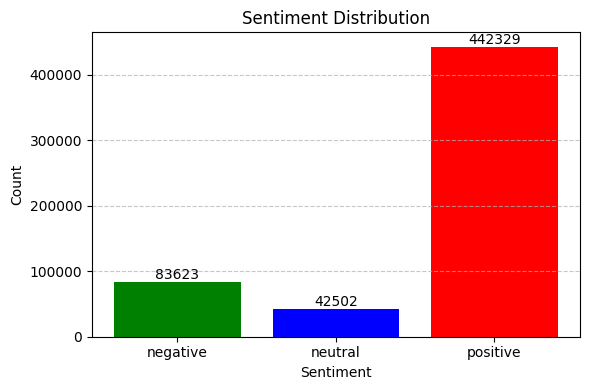

In [0]:
# Examine the distribution of the Sentiment column(Target Variabl)

# Step 1: Count sentiment values and convert to pandas

sentiment_counts = final_df.groupBy("Sentiment").count().toPandas()

# Step 2: Sort for consistent order (optional)
sentiment_counts = sentiment_counts.sort_values("Sentiment")

# Step 3: Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(sentiment_counts["Sentiment"], sentiment_counts["count"], color=["green", "blue", "red"])

# Step 4: Annotate each bar with count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, int(height), ha='center', va='bottom', fontsize=10)

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

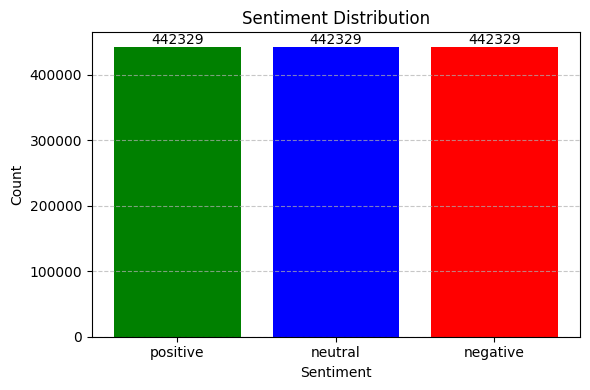

In [0]:
# Balance the target variable column using upsampling method.
# Target count (maximum class size)

target_count = 442329

# Separate each class
positive_df = final_df.filter(col("Sentiment") == "positive")
neutral_df = final_df.filter(col("Sentiment") == "neutral")
negative_df = final_df.filter(col("Sentiment") == "negative")

# Define a reusable upsampling function
def upsample(df: DataFrame, target_size: int) -> DataFrame:
    current_count = df.count()
    multiplier = target_size // current_count
    remainder = target_size % current_count

    df_upsampled = df
    for _ in range(multiplier - 1):
        df_upsampled = df_upsampled.union(df)

    if remainder > 0:
        df_upsampled = df_upsampled.union(df.limit(remainder))

    return df_upsampled

# Apply upsampling to minority classes
neutral_upsampled = upsample(neutral_df, target_count)
negative_upsampled = upsample(negative_df, target_count)

# Combine all into one balanced DataFrame
balanced_df = positive_df.union(neutral_upsampled).union(negative_upsampled)

# Cache the upsampled DataFrame to avoid recomputation
balanced_df = balanced_df.cache()

# Materialize the cache (force computation to happen)
balanced_df.count()

# Step 3: Calculate sentiment distribution (count) for visualization
sentiment_counts = balanced_df.groupBy("Sentiment").count().toPandas()

# Step 4: Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(sentiment_counts["Sentiment"], sentiment_counts["count"], color=["green", "blue", "red"])

# Annotate each bar with the count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, int(height), ha='center', va='bottom', fontsize=10)

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [0]:
# Lable ecode the target variables datapoints for model training.

# Map the Sentiment column to a numeric label directly in place
balanced_df = balanced_df.withColumn(
    "Sentiment", 
    when(col("Sentiment") == "negative", 0)
    .when(col("Sentiment") == "neutral", 1)
    .when(col("Sentiment") == "positive", 2)
    .otherwise(None)  # In case there's any other value that isn't expected
)

# Define the label encoding mapping
label_encoding_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

# Save transformation metadata for label encoding
label_encoding_metadata = {
    'column': 'Sentiment',
    'transformation': 'Label Encoding',
    'encoding': label_encoding_mapping,
    'inverse_function': 'reverse mapping'
}

# Save the metadata in the Databricks File System (DBFS)
os.makedirs("/dbfs/saved_columns", exist_ok=True)
joblib.dump(label_encoding_metadata, "/dbfs/saved_columns/label_encoding_Sentiment.pkl")

# Save the actual label encoding as a separate file if needed
joblib.dump(label_encoding_mapping, "/dbfs/saved_columns/label_encoding_mapping.pkl")

# Show the updated DataFrame with the "Sentiment" column now containing numeric labels
balanced_df.select("Sentiment").show(10, truncate=False)

+---------+
|Sentiment|
+---------+
|2        |
|2        |
|2        |
|2        |
|2        |
|2        |
|2        |
|2        |
|2        |
|2        |
+---------+
only showing top 10 rows


In [0]:
# Examine the schema after balancing the target variable.
balanced_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: float (nullable = true)
 |-- HelpfulnessDenominator: float (nullable = true)
 |-- Time: long (nullable = true)
 |-- Text: string (nullable = true)
 |-- Summary: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Sentiment: integer (nullable = true)



In [0]:
# Drop columns that are not needed for model training.

columns_to_drop = ["Id", "ProductId", "UserId", "ProfileName", 
                   "HelpfulnessNumerator", "HelpfulnessDenominator", "Time", "Text"]

# Only drop columns that exist
existing_columns = [c for c in columns_to_drop if c in balanced_df.columns]

balanced_df = balanced_df.drop(*existing_columns)

In [0]:
# Save the processed data in parquet as processed_data4

balanced_df.write.mode("overwrite").parquet("dbfs:/saved_data/processed_data4.parquet")

In [0]:
#                                 Model Development and Training.


Epoch 1/5
14514/14514 - 417s - 29ms/step - accuracy: 0.7479 - loss: 0.6011 - val_accuracy: 0.8089 - val_loss: 0.4708
Epoch 2/5
14514/14514 - 373s - 26ms/step - accuracy: 0.8185 - loss: 0.4494 - val_accuracy: 0.8401 - val_loss: 0.4024
Epoch 3/5
14514/14514 - 371s - 26ms/step - accuracy: 0.8394 - loss: 0.3971 - val_accuracy: 0.8519 - val_loss: 0.3678
Epoch 4/5
14514/14514 - 373s - 26ms/step - accuracy: 0.8519 - loss: 0.3670 - val_accuracy: 0.8617 - val_loss: 0.3479
Epoch 5/5
14514/14514 - 383s - 26ms/step - accuracy: 0.8592 - loss: 0.3486 - val_accuracy: 0.8681 - val_loss: 0.3322
✅ Evaluating on Training Set...

📊 Training Metrics:
  - Accuracy :  0.8849
  - Precision:  0.8853
  - Recall   :  0.8849
  - F1 Score :  0.8850
  - AUC      :  0.9781


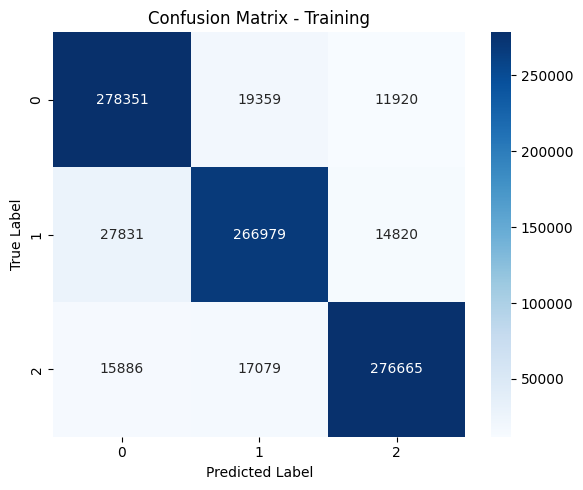

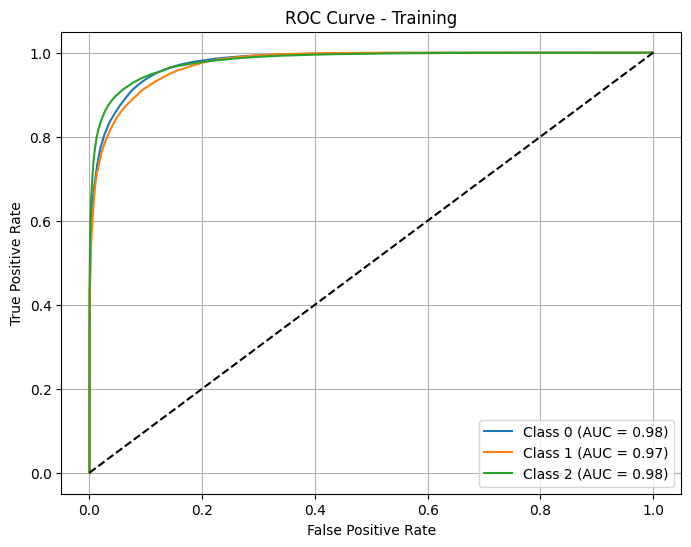

✅ Evaluating on Validation Set...

📊 Validation Metrics:
  - Accuracy :  0.8681
  - Precision:  0.8688
  - Recall   :  0.8681
  - F1 Score :  0.8681
  - AUC      :  0.9702


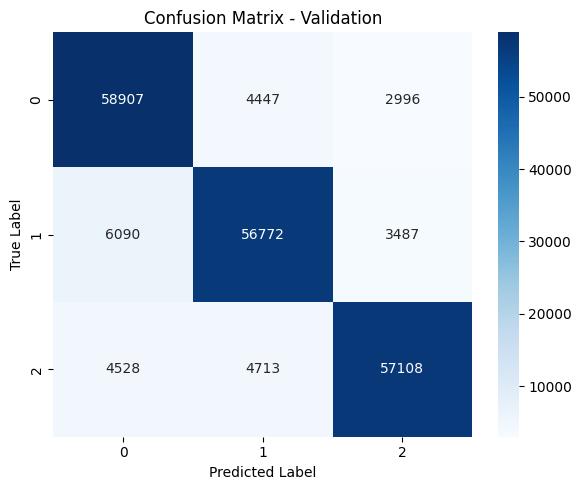

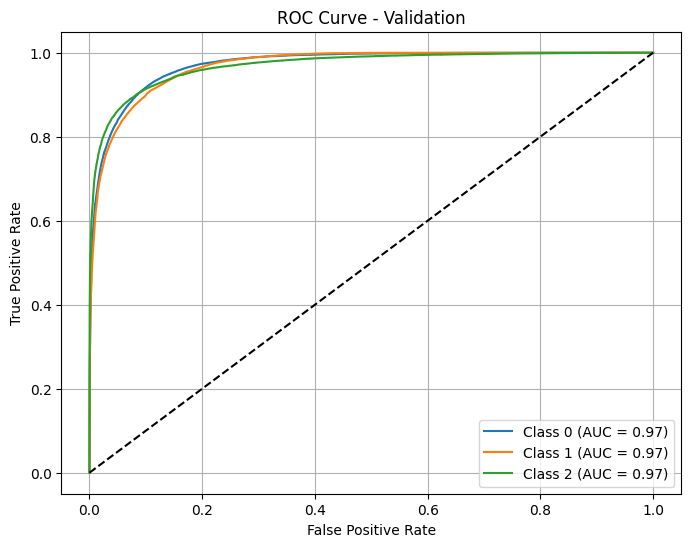

✅ Evaluating on Test Set...

📊 Test Metrics:
  - Accuracy :  0.8682
  - Precision:  0.8690
  - Recall   :  0.8682
  - F1 Score :  0.8683
  - AUC      :  0.9703


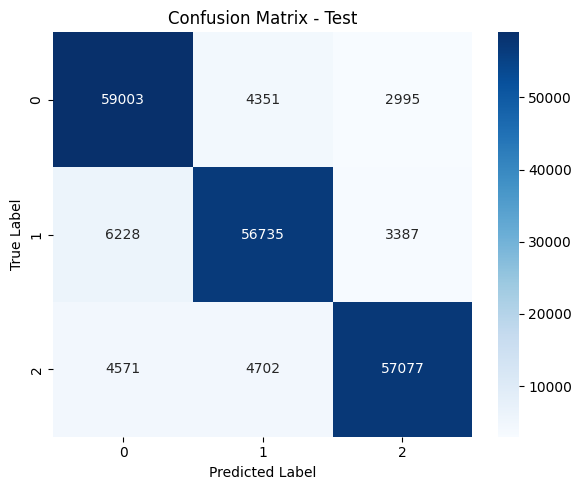

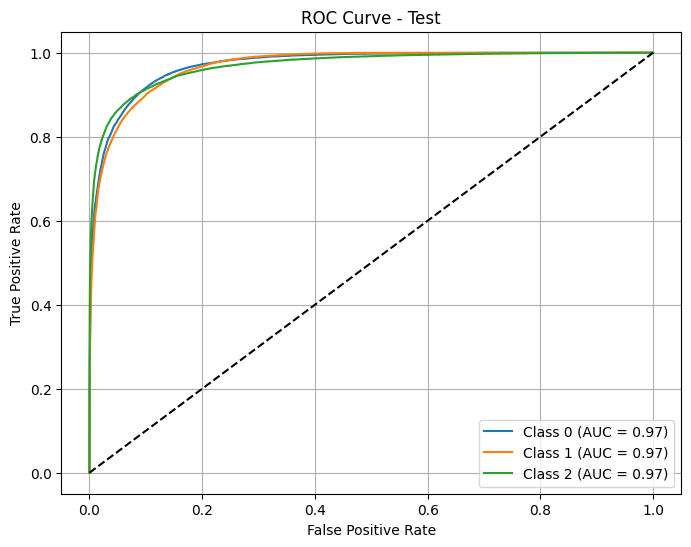

'/dbfs/models/cnn_sentiment_model.keras'

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import shutil


# Load the preprocessed dataset with padded_summary
df = spark.read.parquet("dbfs:/saved_data/model_data4.parquet")

# Convert Spark DataFrame to Pandas
pandas_df = df.select("Summary", "Sentiment").toPandas()

# Extract features and labels
X = np.array(pandas_df["Summary"].tolist())  # padded_summary already in list form
y = to_categorical(np.array(pandas_df["Sentiment"]))  # One-hot encoding (3 classes)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y.argmax(1), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp.argmax(1), random_state=42)

# Hyperparameters
vocab_size = 20000
embedding_dim = 128
max_len = 100  # From tokenizer config
num_classes = 3
dropout_rate = 0.3
batch_size = 64
epochs = 5

# Build CNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=2  # Only show 1 line per epoch
)

# Evaluation function
def evaluate_model(model, X, y, dataset_name="Dataset"):
    y_pred_probs = model.predict(X, verbose=0)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y.argmax(axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y, y_pred_probs, multi_class='ovr')

    print(f"\n📊 {dataset_name} Metrics:")
    print(f"  - Accuracy :  {accuracy:.4f}")
    print(f"  - Precision:  {precision:.4f}")
    print(f"  - Recall   :  {recall:.4f}")
    print(f"  - F1 Score :  {f1:.4f}")
    print(f"  - AUC      :  {auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # ROC curve
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc_score(y[:, i], y_pred_probs[:, i]):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run evaluations
print("✅ Evaluating on Training Set...")
evaluate_model(model, X_train, y_train, "Training")

print("✅ Evaluating on Validation Set...")
evaluate_model(model, X_val, y_val, "Validation")

print("✅ Evaluating on Test Set...")
evaluate_model(model, X_test, y_test, "Test")

# Local save
model.save("cnn_sentiment_model.keras")

# Move to DBFS
os.makedirs("/dbfs/models", exist_ok=True)
shutil.move("cnn_sentiment_model.keras", "/dbfs/models/cnn_sentiment_model.keras")
